In [15]:
"""Trains a ResNet on the CIFAR10 dataset.
 
ResNet v1
[a] Deep Residual Learning for Image Recognition
https://arxiv.org/pdf/1512.03385.pdf
 
ResNet v2
[b] Identity Mappings in Deep Residual Networks
https://arxiv.org/pdf/1603.05027.pdf
"""
 
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os
 
K.set_image_data_format('channels_first')
 
# Training parameters
batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 10
data_augmentation = True
num_classes = 10
 
# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True
 
# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 3
 
# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 1
 
# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2
 
# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)
 
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
 
# Input image dimensions.
input_shape = x_train.shape[1:]

In [16]:
input_shape

(3, 32, 32)

In [17]:
x_train_reshaped = x_train.reshape((50000,32,32,3))

In [18]:
x_train.shape

(50000, 3, 32, 32)

In [25]:
# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
 
# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean
 
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)
 
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
 
 
def lr_schedule(epoch):
    """Learning Rate Schedule
 
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
 
    # Arguments
        epoch (int): The number of epochs
 
    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr
 
 
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
 
    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            activation-bn-conv (False)
 
    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))
 
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x
 
 
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]
 
    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M
 
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
 
    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)
 
    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2
 
    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)
 
    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model
 
 
def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]
 
    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256
 
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
 
    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)
 
    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)
 
    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample
 
            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
 
        num_filters_in = num_filters_out
 
    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)
 
    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model
 
 
if version == 2:
    model = resnet_v2(input_shape=input_shape, depth=depth)
else:
    model = resnet_v1(input_shape=input_shape, depth=depth)
 
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)

x_train shape: (50000, 3, 32, 32)
50000 train samples
10000 test samples
y_train shape: (50000, 1)
Instructions for updating:
Colocations handled automatically by placer.
Learning rate:  0.001
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 3, 32, 32)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 32, 32)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 32, 32)   128         conv2d_1[0][0]                   
_________________________________________________________________________________________________

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import csv

predictions_df = pd.read_csv(r'C:\Users\tay.yq.XTRAMAN\Downloads\shopee dataset\test.csv', header=0)

In [31]:
predictions_df.head()

,filename,category
0,fd663cf2b6e1d7b02938c6aaae0a32d2.jpg,43
1,c7fd77508a8c355eaab0d4e10efd6b15.jpg,43
2,127f3e6d6e3491b2459812353f33a913.jpg,43
3,5ca4f2da11eda083064e6c36f37eeb81.jpg,43
4,46d681a542f2c71be017eef6aae23313.jpg,43


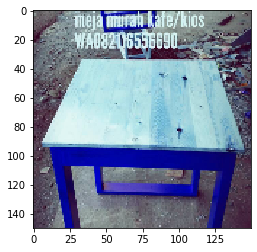

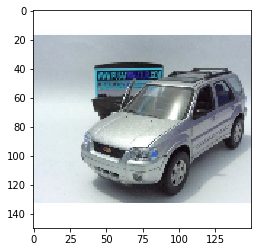

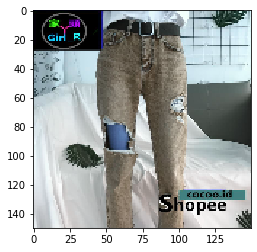

In [49]:
test_dir = r'C:\Users\tay.yq.XTRAMAN\Downloads\shopee dataset\test\test'
    
with open('predictions.csv', mode='w', newline='') as predict_file:
    predict_file = csv.writer(predict_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    predict_file.writerow(['filename', 'category'])
                           
    for i in range(3):
        predict_file.writerow([predictions_df.loc[i, 'filename'], i])
        img_path = os.path.join(test_dir, predictions_df.loc[i, 'filename'])
        img = cv2.imread(img_path)
        img = cv2.resize(img, dsize=(150,150))
        plt.imshow(img)
        plt.show()

In [48]:
105398/2636

39.98406676783004